In [ ]:
# --- Part 0: 環境準備 ---
# 1. 安裝 PyTorch 和對應的 torchvision, torchaudio

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# 安裝 tifffile 和 imagecodecs
!pip install tifffile imagecodecs
# 安裝albumentations
!pip install albumentations==1.0.3
# 2. 安裝 Detectron2
!pip install -U cython pyyaml==6.0
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# 3. Clone Detectron2
!rm -rf detectron2_repo
!git clone https://github.com/facebookresearch/detectron2.git detectron2_repo
print("Detectron2 repo (main branch) cloned to 'detectron2_repo'")

Looking in indexes: https://download.pytorch.org/whl/cu121
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━ 570.9/780.5 MB 214.3 MB/s eta 0:00:01
ERROR: Operation cancelled by user
^C
Traceback (most recent call last):
object address  : 0x7f131d360640
object refcount : 2
object type     : 0x9d5ea0
object type name: KeyboardInterrupt
object repr     : KeyboardInterrupt()
lost sys.stderr
^C
^C
^C
^C
Cloning into 'detectron2_repo'...
remote: Enumerating objects: 15860, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (64/64), done.


In [ ]:
# --- 必要導入---
import torch
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg, CfgNode
from detectron2.modeling import build_model
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_train_loader
from detectron2.data import detection_utils as utils
from detectron2.structures import BoxMode
from pycocotools import mask as mask_util
import os
from pathlib import Path
import numpy as np
import cv2
import random
import tifffile
import copy

# Albumentations 導入
import albumentations as A

from google.colab.patches import cv2_imshow # 如果有視覺化


# 4. 將 PointRend 專案路徑添加到 sys.path 並導入
import sys

point_rend_path_from_clone = "detectron2_repo/projects/PointRend"
if os.path.exists(point_rend_path_from_clone): # 確保路徑存在
    if point_rend_path_from_clone not in sys.path:
        sys.path.insert(1, point_rend_path_from_clone)
        print(f"Added '{point_rend_path_from_clone}' to sys.path")
else:
    print(f"WARNING: Cloned directory '{point_rend_path_from_clone}' not found. PointRend import might fail.")

POINTREND_PROJECT_AVAILABLE_AND_SETUP = False
try:
    import point_rend
    print("Successfully imported 'point_rend' module from detectron2_repo.")
    POINTREND_PROJECT_AVAILABLE_AND_SETUP = True
except ImportError:
    try:
        import detectron2.projects.point_rend as point_rend_pkg
        point_rend = point_rend_pkg
        print("Successfully imported 'point_rend' module from installed detectron2 package.")
        POINTREND_PROJECT_AVAILABLE_AND_SETUP = True
    except ImportError as e_pip:
        print(f"ERROR: Failed to import 'point_rend' from both cloned repo and pip package: {e_pip}")
        print("PointRend functionalities will not be available.")
        print("Ensure Detectron2 is correctly installed and 'projects/PointRend' is accessible.")





Added 'detectron2_repo/projects/PointRend' to sys.path
Successfully imported 'point_rend' module from detectron2_repo.


Mounted at /content/drive
用於訓練/驗證的總影像數: 209
訓練影像數: 167
驗證影像數: 42


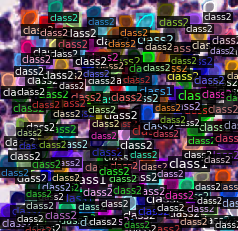

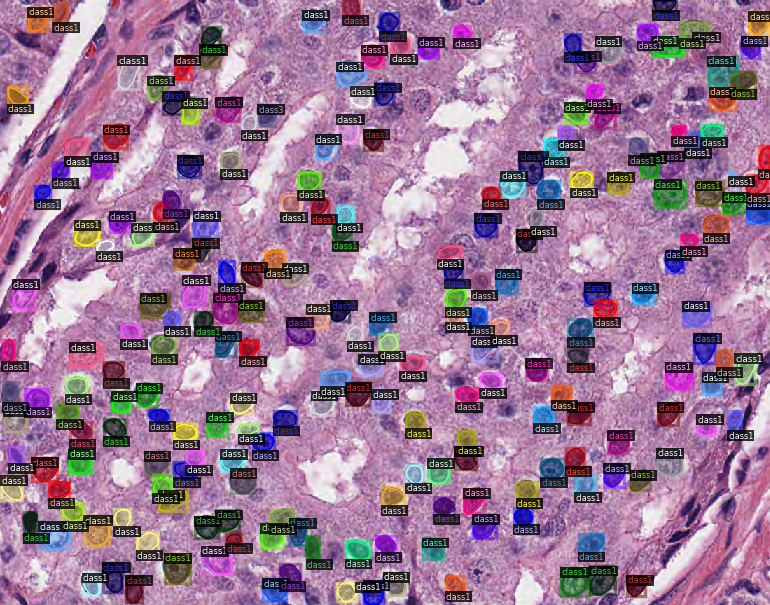

In [ ]:


from detectron2.utils.visualizer import Visualizer, ColorMode
# --- 1. 掛載 Google Drive 並設定路徑 ---
CLASS_NAMES = ["class1", "class2", "class3", "class4"]
BASE_DIR = Path('/content/drive/MyDrive/hw3-data-release')
from google.colab import drive
drive.mount('/content/drive')

# 將此路徑修改為在GoogleDrive中存放資料集的位置
BASE_DIR = Path('/content/drive/MyDrive/hw3-data-release')
TRAIN_VAL_DIR = BASE_DIR / 'train'
TEST_IMG_DIR = BASE_DIR / 'test'
TEST_JSON_PATH = BASE_DIR / 'test_image_name_to_ids.json'

# 定義類別名稱
CLASS_NAMES = ["class1", "class2", "class3", "class4"]

# --- 2. 資料載入與預處理函式 ---
def get_cell_instance_dicts(image_folder_names, base_img_dir_path):
    dataset_dicts = []
    for img_folder_name in image_folder_names:
        record = {}

        image_file_path_str = str(base_img_dir_path / img_folder_name / "image.tif")

        try:
            image = tifffile.imread(image_file_path_str)
            original_dtype = image.dtype

            if image.ndim == 2:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            elif image.shape[2] == 1:
                image = cv2.cvtColor(image[:,:,0], cv2.COLOR_GRAY2RGB)
            elif image.shape[2] == 4:
                image = image[:,:,:3]
            elif image.shape[2] > 3 :
                print(f"警告：影像 {image_file_path_str} 有 {image.shape[2]} 個通道。將取前3個通道。")
                image = image[:,:,:3]

            if image.dtype != np.uint8:
                max_val = np.max(image)
                if max_val > 0:
                    image = (image / max_val * 255).astype(np.uint8)
                else:
                    image = image.astype(np.uint8)

            height, width = image.shape[:2]
        except Exception as e:
            print(f"讀取影像 {image_file_path_str} 或轉換時發生錯誤: {e}")
            continue

        record["file_name"] = image_file_path_str
        record["image_id"] = img_folder_name
        record["height"] = height
        record["width"] = width

        annotations = []
        for class_idx, class_name in enumerate(CLASS_NAMES):
            mask_file_path_str = str(base_img_dir_path / img_folder_name / f"{class_name}.tif")

            if os.path.exists(mask_file_path_str):
                try:

                    instance_mask_for_class_type = tifffile.imread(mask_file_path_str)
                except Exception as e:
                    print(f"讀取遮罩 {mask_file_path_str} 時發生錯誤: {e}")
                    continue

                unique_instance_pixel_values = np.unique(instance_mask_for_class_type)

                unique_instance_pixel_values = unique_instance_pixel_values[unique_instance_pixel_values != 0]

                for instance_value in unique_instance_pixel_values:

                    binary_instance_mask = (instance_mask_for_class_type == instance_value).astype(np.uint8)

                    if np.sum(binary_instance_mask) == 0:
                        continue


                    ys, xs = np.where(binary_instance_mask > 0)
                    if len(xs) == 0 or len(ys) == 0: continue

                    xmin, xmax = float(np.min(xs)), float(np.max(xs))
                    ymin, ymax = float(np.min(ys)), float(np.max(ys))


                    rle = mask_util.encode(np.asfortranarray(binary_instance_mask))

                    obj = {
                        "bbox": [xmin, ymin, xmax, ymax],
                        "bbox_mode": BoxMode.XYXY_ABS, # 絕對座標
                        "segmentation": rle, # 使用 pycocotools RLE 格式
                        "category_id": class_idx, # 0 索引的類別 ID
                    }
                    annotations.append(obj)
        record["annotations"] = annotations
        dataset_dicts.append(record)
    return dataset_dicts

# --- 3. 資料集註冊 ---
# 獲取訓練/驗證目錄中所有影像資料夾的列表
all_image_folders = sorted([d.name for d in TRAIN_VAL_DIR.iterdir() if d.is_dir()])
random.seed(42)
random.shuffle(all_image_folders)

# 分割資料集：總共 209 張影像用於訓練/驗證。使用約 80% 作為訓練集，20% 作為驗證集。
num_total_train_val = len(all_image_folders)
num_train = int(num_total_train_val * 0.8)
train_image_ids = all_image_folders[:num_train]
val_image_ids = all_image_folders[num_train:]

print(f"用於訓練/驗證的總影像數: {num_total_train_val}")
print(f"訓練影像數: {len(train_image_ids)}")
print(f"驗證影像數: {len(val_image_ids)}")

# 註冊資料集到 Detectron2
for d_name, ids_subset in [("train", train_image_ids), ("val", val_image_ids)]:
    dataset_name_registered = f"cells_{d_name}"
    DatasetCatalog.register(dataset_name_registered, lambda ids=ids_subset: get_cell_instance_dicts(ids, TRAIN_VAL_DIR))
    MetadataCatalog.get(dataset_name_registered).set(thing_classes=CLASS_NAMES)

#驗證資料集載入並視覺化一些樣本
cells_metadata_train = MetadataCatalog.get("cells_train")
sample_dicts_to_visualize = get_cell_instance_dicts(train_image_ids[:2], TRAIN_VAL_DIR) # 取前兩個訓練樣本
for d_sample in sample_dicts_to_visualize:
    loaded_img_for_viz = tifffile.imread(d_sample["file_name"])

    if loaded_img_for_viz.ndim == 2: loaded_img_for_viz = cv2.cvtColor(loaded_img_for_viz, cv2.COLOR_GRAY2RGB)
    elif loaded_img_for_viz.shape[2] == 1: loaded_img_for_viz = cv2.cvtColor(loaded_img_for_viz[:,:,0], cv2.COLOR_GRAY2RGB)
    elif loaded_img_for_viz.shape[2] == 4: loaded_img_for_viz = loaded_img_for_viz[:,:,:3]
    elif loaded_img_for_viz.shape[2] > 3: loaded_img_for_viz = loaded_img_for_viz[:,:,:3]
    if loaded_img_for_viz.dtype != np.uint8:
        max_val_viz = np.max(loaded_img_for_viz)
        if max_val_viz > 0: loaded_img_for_viz = (loaded_img_for_viz / max_val_viz * 255).astype(np.uint8)
        else: loaded_img_for_viz = loaded_img_for_viz.astype(np.uint8)

    visualizer = Visualizer(loaded_img_for_viz[:, :, ::-1], metadata=cells_metadata_train, scale=0.7)
    vis_output = visualizer.draw_dataset_dict(d_sample)
    cv2_imshow(vis_output.get_image()[:, :, ::-1])




In [ ]:
# --- 4. 模型設定 ---
from detectron2.config import get_cfg, CfgNode
from detectron2 import model_zoo
from detectron2.modeling import build_model
import os

# === PointRend 相關導入 ===
POINTREND_PROJECT_AVAILABLE_AND_SETUP = False
POINTREND_CONFIG_SUCCESSFULLY_APPLIED = False # 用於追蹤 PointRend 是否真的配置成功
try:
    import point_rend
    print("Successfully imported 'point_rend' module (likely from detectron2_repo).")
    POINTREND_PROJECT_AVAILABLE_AND_SETUP = True
except ImportError:
    try:
        import detectron2.projects.point_rend as point_rend_pkg
        point_rend = point_rend_pkg
        print("Successfully imported 'point_rend' module from installed detectron2 package.")
        POINTREND_PROJECT_AVAILABLE_AND_SETUP = True
    except ImportError as e_final:
        print(f"ERROR: Failed to import 'point_rend' module: {e_final}")
        print("PointRend functionalities will not be available.")
# === PointRend 導入結束 ===

cfg = get_cfg()
cfg.INPUT.MASK_FORMAT = "bitmask"
MODEL_DESCRIPTION_FOR_OUTPUT = "X101_FPN_NoPointRend_v013"

if POINTREND_PROJECT_AVAILABLE_AND_SETUP:
    print("PointRend 專案可用，將調用 add_pointrend_config(cfg) 以確保配置結構存在。")
    point_rend.add_pointrend_config(cfg) # 步驟1: 添加 PointRend 的預設配置結構

    pointrend_x101_yaml_path = "detectron2_repo/projects/PointRend/configs/InstanceSegmentation/pointrend_rcnn_X_101_32x8d_FPN_3x_coco.yaml"

    if os.path.exists(pointrend_x101_yaml_path):
        try:
            cfg.merge_from_file(pointrend_x101_yaml_path) # 步驟2: 用 YAML 的值覆蓋
            print(f"已成功從 '{pointrend_x101_yaml_path}' 載入 PointRend X101 設定。")

            path_to_your_downloaded_weights = str(BASE_DIR / "model_final_ba17b9.pkl")
            if os.path.exists(path_to_your_downloaded_weights):
                cfg.MODEL.WEIGHTS = path_to_your_downloaded_weights
                print(f"將使用您提供的本地預訓練權重: {cfg.MODEL.WEIGHTS}")
            elif not cfg.MODEL.WEIGHTS:
                print(f"警告：YAML 未指定 MODEL.WEIGHTS，且未找到本地權重。將使用標準 ResNeXt-101 FPN 骨幹權重。")
                cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
            else:
                print(f"將使用 PointRend X101 YAML 中指定的權重: {cfg.MODEL.WEIGHTS}")

            MODEL_DESCRIPTION_FOR_OUTPUT = "PointRend_X101_PKL_v013"
            POINTREND_CONFIG_SUCCESSFULLY_APPLIED = True
        except Exception as e:
            print(f"從 '{pointrend_x101_yaml_path}' 載入 YAML 失敗: {e}。")

            print("將回退到標準 ResNeXt-101 FPN 設定，並手動配置 PointRend。")
            cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
            point_rend.add_pointrend_config(cfg)
            cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
            cfg.defrost()
            cfg.MODEL.POINT_HEAD.ENABLED = True
            cfg.MODEL.ROI_MASK_HEAD.NAME = "PointRendMaskHead"
            cfg.MODEL.ROI_MASK_HEAD.POINT_HEAD_ON = True
            cfg.MODEL.ROI_HEADS.NAME = "PointRendROIHeads"

            print("已作為回退方案，手動配置了 PointRend 組件。")
            MODEL_DESCRIPTION_FOR_OUTPUT = "ManuallyCfg_PointRend_X101_v013"
            POINTREND_CONFIG_SUCCESSFULLY_APPLIED = True
    else:
        print(f"警告：指定的 PointRend YAML 檔案 '{pointrend_x101_yaml_path}' 不存在。將嘗試手動配置 PointRend。")
        cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
        cfg.defrost()
        cfg.MODEL.POINT_HEAD.ENABLED = True
        cfg.MODEL.ROI_MASK_HEAD.NAME = "PointRendMaskHead"
        cfg.MODEL.ROI_MASK_HEAD.POINT_HEAD_ON = True
        cfg.MODEL.ROI_HEADS.NAME = "PointRendROIHeads"
        # cfg.freeze()
        print("已手動配置 PointRend 組件。")
        MODEL_DESCRIPTION_FOR_OUTPUT = "ManuallyCfg_PointRend_X101_v013"
        POINTREND_CONFIG_SUCCESSFULLY_APPLIED = True
else:
    print("PointRend 專案未正確設定或導入，將使用標準 ResNeXt-101 FPN (不含 PointRend)。")
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
    if cfg.MODEL.get("POINT_HEAD"):
        cfg.defrost()
        cfg.MODEL.POINT_HEAD.ENABLED = False
        # cfg.freeze()
    POINTREND_CONFIG_SUCCESSFULLY_APPLIED = False


# === 針對任務進行修改 ===
cfg.DATASETS.TRAIN = ("cells_train",)
cfg.DATASETS.TEST = ("cells_val",)
cfg.DATALOADER.NUM_WORKERS = 12

cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- 設定並同步 NUM_CLASSES---
cfg.defrost()
# 設定 ROI_HEADS 的類別數
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(CLASS_NAMES)
print(f"已將 cfg.MODEL.ROI_HEADS.NUM_CLASSES 設定為: {cfg.MODEL.ROI_HEADS.NUM_CLASSES}")

if POINTREND_CONFIG_SUCCESSFULLY_APPLIED:

    if not cfg.MODEL.get("POINT_HEAD"):
        print("錯誤：POINT_HEAD 節點未定義，即使 PointRend 被認為已配置！")

        cfg.MODEL.POINT_HEAD = CfgNode()
        cfg.MODEL.POINT_HEAD.ENABLED = False
        MODEL_DESCRIPTION_FOR_OUTPUT += "_PointHeadNodeMissingError"
    else: # POINT_HEAD 節點存在
        if not cfg.MODEL.POINT_HEAD.get("ENABLED", False):
            print("警告: POINT_HEAD.ENABLED 在配置中為 False 或未設定，現強制設為 True 以啟用 PointRend。")
            cfg.MODEL.POINT_HEAD.ENABLED = True

        # 確保 NUM_CLASSES 屬性存在於 POINT_HEAD 中
        if "NUM_CLASSES" not in cfg.MODEL.POINT_HEAD:
             cfg.MODEL.POINT_HEAD.NUM_CLASSES = -1
        cfg.MODEL.POINT_HEAD.NUM_CLASSES = cfg.MODEL.ROI_HEADS.NUM_CLASSES
        print(f"已將 cfg.MODEL.POINT_HEAD.NUM_CLASSES 同步為: {cfg.MODEL.POINT_HEAD.NUM_CLASSES}")

        # 強制設定/確認 PointRend 的關鍵頭部名稱和開關
        expected_roi_mask_head_name = "PointRendMaskHead"
        expected_roi_heads_name = "PointRendROIHeads"
        if cfg.MODEL.ROI_MASK_HEAD.NAME != expected_roi_mask_head_name:
            print(f"將 ROI_MASK_HEAD.NAME 從 '{cfg.MODEL.ROI_MASK_HEAD.NAME}' 強制設定為 '{expected_roi_mask_head_name}'")
            cfg.MODEL.ROI_MASK_HEAD.NAME = expected_roi_mask_head_name
        if not cfg.MODEL.ROI_MASK_HEAD.get("POINT_HEAD_ON", False):
             print(f"將 ROI_MASK_HEAD.POINT_HEAD_ON 強制設定為 True")
             cfg.MODEL.ROI_MASK_HEAD.POINT_HEAD_ON = True
        if cfg.MODEL.ROI_HEADS.NAME != expected_roi_heads_name:
            print(f"將 ROI_HEADS.NAME 從 '{cfg.MODEL.ROI_HEADS.NAME}' 強制設定為 '{expected_roi_heads_name}'")
            cfg.MODEL.ROI_HEADS.NAME = expected_roi_heads_name
else: # 如果 PointRend 未被成功配置
    if cfg.MODEL.get("POINT_HEAD") and cfg.MODEL.POINT_HEAD.get("ENABLED", False):
        print("警告：PointRend 似乎未成功配置，但 POINT_HEAD 仍為啟用狀態。將強制禁用以避免錯誤。")
        cfg.MODEL.POINT_HEAD.ENABLED = False
# --- NUM_CLASSES 設定結束 ---

# === SOLVER設定 ===
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001

cfg.SOLVER.MAX_ITER = 8000

cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.WARMUP_FACTOR = 1.0 / 1000
cfg.SOLVER.WARMUP_METHOD = "linear"


cfg.SOLVER.STEPS = []
cfg.SOLVER.GAMMA = 0.1

cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True
cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE = "norm"
cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE = 1.0
cfg.SOLVER.CLIP_GRADIENTS.NORM_TYPE = 2.0

cfg.SOLVER.CHECKPOINT_PERIOD = 2000
cfg.TEST.EVAL_PERIOD = 2000


# 更新輸出目錄描述
final_model_desc = MODEL_DESCRIPTION_FOR_OUTPUT
cfg.OUTPUT_DIR = str(BASE_DIR / f"output_{final_model_desc}_Warmup_Clip_8kIter_Final_v3_AssertionFix_longtrain")
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# 在所有配置值設定完成後，凍結 cfg
cfg.freeze()

# --- 檢查模型大小 ---
temp_model_for_param_check = build_model(cfg)
total_parameters = sum(p.numel() for p in temp_model_for_param_check.parameters())
trainable_parameters = sum(p.numel() for p in temp_model_for_param_check.parameters() if p.requires_grad)
print(f"模型：{final_model_desc}")
print(f"總參數數量：{total_parameters/1e6:.2f}M")
print(f"可訓練參數數量：{trainable_parameters/1e6:.2f}M")
del temp_model_for_param_check

# --- 5. 設定訓練器並開始訓練 ---
class CocoTrainerWithEval(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "coco_eval_val_set")
        return COCOEvaluator(dataset_name, cfg, distributed=False, output_dir=output_folder, use_fast_impl=False)

trainer = CocoTrainerWithEval(cfg)
trainer.resume_or_load(resume=False)
try:
    print(f"--- 開始訓練 (模型：{final_model_desc}, 迭代次數：{cfg.SOLVER.MAX_ITER}) ---")
    print(f"--- 設定檔儲存於: {cfg.OUTPUT_DIR} ---")
    print(f"--- 使用的預訓練權重: {cfg.MODEL.WEIGHTS} ---")
    print(f"--- ROI_HEADS.NUM_CLASSES: {cfg.MODEL.ROI_HEADS.NUM_CLASSES} ---")
    if cfg.MODEL.get("POINT_HEAD") and cfg.MODEL.POINT_HEAD.get("ENABLED"):
        print(f"--- POINT_HEAD.NUM_CLASSES: {cfg.MODEL.POINT_HEAD.NUM_CLASSES} ---")
    trainer.train()
except Exception as e:
    print(f"訓練被中斷或發生錯誤: {e}")
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    with open(os.path.join(cfg.OUTPUT_DIR, "config_at_error_time.yaml"), "w") as f_err:
        f_err.write(cfg.dump())
    raise e
finally:
    print("--- 訓練完成或已停止 ---")
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    with open(os.path.join(cfg.OUTPUT_DIR, "config_final_training.yaml"), "w") as f_final:
        f_final.write(cfg.dump())

Successfully imported 'point_rend' module (likely from detectron2_repo).
PointRend 專案可用，將調用 add_pointrend_config(cfg) 以確保配置結構存在。
已成功從 'detectron2_repo/projects/PointRend/configs/InstanceSegmentation/pointrend_rcnn_X_101_32x8d_FPN_3x_coco.yaml' 載入 PointRend X101 設定。
將使用您提供的本地預訓練權重: /content/drive/MyDrive/hw3-data-release/model_final_ba17b9.pkl
已將 cfg.MODEL.ROI_HEADS.NUM_CLASSES 設定為: 4
警告: POINT_HEAD.ENABLED 在配置中為 False 或未設定，現強制設為 True 以啟用 PointRend。
已將 cfg.MODEL.POINT_HEAD.NUM_CLASSES 同步為: 4
將 ROI_HEADS.NAME 從 'StandardROIHeads' 強制設定為 'PointRendROIHeads'
模型：PointRend_X101_PKL_v013
總參數數量：118.96M
可訓練參數數量：118.53M
[05/07 12:02:55 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

[05/07 06:00:41 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/hw3-data-release/output_PointRend_X101_PKL_v013_Warmup_Clip_8kIter_Final_v3_AssertionFix/model_final.pth ...


/usr/local/lib/python3.11/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))


--- 開始為 101 張測試影像產生預測 ---

提交檔案已儲存至: /content/drive/MyDrive/hw3-data-release/test-results.json
提交檔案中總實例數: 4698

--- 視覺化一些測試影像的預測結果 ---
正在顯示 b270d133-be95-41bd-b336-bc5b1a1e33c8.tif 的預測結果


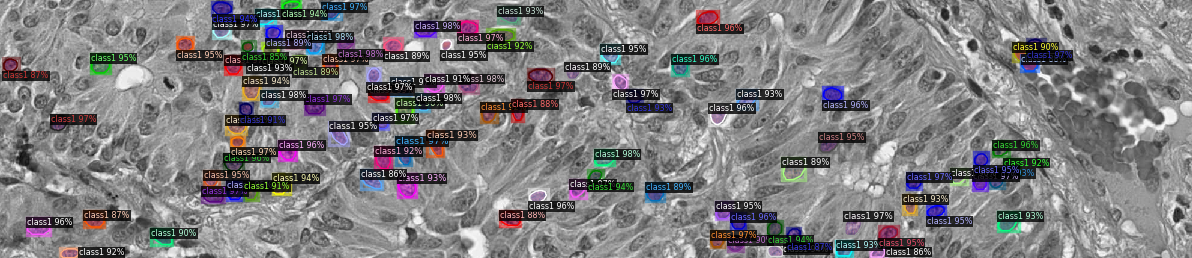

正在顯示 4b7ae742-03c2-4c4a-9a9d-0cf5c389a07d.tif 的預測結果


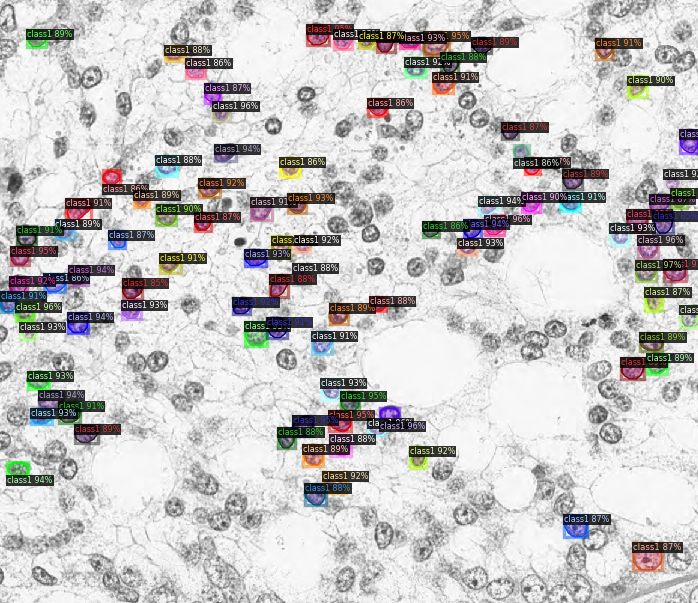

正在顯示 8e1465e1-2870-471f-b5a7-501bf564f815.tif 的預測結果


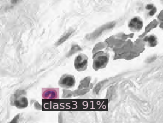


--- 腳本執行完畢 ---


In [ ]:
# --- 6. 推論 ---
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
import json

cfg.defrost()

# 載入最佳或最後訓練的模型
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # 設定測試時的偵測信心度閾值
predictor = DefaultPredictor(cfg)

# 載入測試影像的元資料
try:
    with open(TEST_JSON_PATH, 'r') as f_json:
        test_metadata_list_from_json = json.load(f_json)
except FileNotFoundError:
    print(f"錯誤：找不到測試 JSON 檔案於 {TEST_JSON_PATH}")
    test_metadata_list_from_json = []
except json.JSONDecodeError:
    print(f"錯誤：解析測試 JSON 檔案 {TEST_JSON_PATH} 失敗。請檢查格式。")
    test_metadata_list_from_json = []



if isinstance(test_metadata_list_from_json, dict) and "file_name" in test_metadata_list_from_json:
    print("偵測到 test_image_name_to_ids.json 是單一項目，將其轉換為列表。")
    test_metadata_list_from_json = [test_metadata_list_from_json]
elif not isinstance(test_metadata_list_from_json, list):
    print(f"警告: test_image_name_to_ids.json 不是預期的列表格式。將嘗試從 {TEST_IMG_DIR} 列出 .tif 檔案。")
    test_metadata_list_from_json = []


submission_output_list = []
print(f"\n--- 開始為 {len(test_metadata_list_from_json)} 張測試影像產生預測 ---")

for test_image_info in test_metadata_list_from_json:
    test_file_name = test_image_info.get("file_name")

    submission_image_id = test_image_info.get("id")
    expected_height = test_image_info.get("height")
    expected_width = test_image_info.get("width")

    if not test_file_name or submission_image_id is None:
        print(f"跳過項目，因缺少 'file_name' 或 'id': {test_image_info}")
        continue

    current_test_image_path = TEST_IMG_DIR / test_file_name

    if not current_test_image_path.exists():
        print(f"找不到測試影像: {current_test_image_path}。跳過。")
        continue

    try:

        img_for_prediction_raw = tifffile.imread(current_test_image_path)
        img_for_prediction = img_for_prediction_raw.copy()

        if img_for_prediction.ndim == 2: img_for_prediction = cv2.cvtColor(img_for_prediction, cv2.COLOR_GRAY2RGB)
        elif img_for_prediction.shape[2] == 1: img_for_prediction = cv2.cvtColor(img_for_prediction[:,:,0], cv2.COLOR_GRAY2RGB)
        elif img_for_prediction.shape[2] == 4: img_for_prediction = img_for_prediction[:,:,:3]
        elif img_for_prediction.shape[2] > 3: img_for_prediction = img_for_prediction[:,:,:3]

        if img_for_prediction.dtype != np.uint8:
            max_val_pred = np.max(img_for_prediction)
            if max_val_pred > 0: img_for_prediction = (img_for_prediction / max_val_pred * 255).astype(np.uint8)
            else: img_for_prediction = img_for_prediction.astype(np.uint8)

        if expected_height is not None and img_for_prediction.shape[0] != expected_height:
            print(f"警告：影像 {test_file_name} 的高度 ({img_for_prediction.shape[0]}) 與 JSON 中的高度 ({expected_height}) 不符。")
        if expected_width is not None and img_for_prediction.shape[1] != expected_width:
            print(f"警告：影像 {test_file_name} 的寬度 ({img_for_prediction.shape[1]}) 與 JSON 中的寬度 ({expected_width}) 不符。")


    except Exception as e:
        print(f"讀取或處理測試影像 {current_test_image_path} 時發生錯誤: {e}。跳過。")
        continue


    prediction_outputs = predictor(img_for_prediction)

    instances = prediction_outputs["instances"].to("cpu")
    predicted_masks_tensor = instances.pred_masks
    predicted_boxes_obj = instances.pred_boxes
    predicted_classes_tensor = instances.pred_classes
    predicted_scores_tensor = instances.scores

    num_detected_instances = len(instances)


    for i in range(num_detected_instances):
        binary_mask_numpy = predicted_masks_tensor[i].numpy().astype(np.uint8)
        class_id_0_indexed = predicted_classes_tensor[i].item()
        score_val = predicted_scores_tensor[i].item()
        bbox_coords_xyxy = predicted_boxes_obj[i].tensor.numpy()[0].tolist()


        submission_category_id = class_id_0_indexed + 1


        rle_encoded_mask = mask_util.encode(np.asfortranarray(binary_mask_numpy))

        rle_encoded_mask['counts'] = rle_encoded_mask['counts'].decode('utf-8')


        submission_output_list.append({
            "image_id": submission_image_id,
            "bbox": bbox_coords_xyxy,
            "score": float(score_val),
            "category_id": submission_category_id,
            "segmentation": rle_encoded_mask
        })

# 儲存提交檔案
submission_file_output_path = BASE_DIR / "test-results.json"
    with open(submission_file_output_path, 'w') as f_submit:
        json.dump(submission_output_list, f_submit, indent=2)
    print(f"\n提交檔案已儲存至: {submission_file_output_path}")
    print(f"提交檔案中總實例數: {len(submission_output_list)}")
except Exception as e:
    print(f"儲存提交檔案時發生錯誤: {e}")


#--- 測試影像上視覺化預測結果 ---
print("\n--- 視覺化一些測試影像的預測結果 ---")
num_test_images_to_visualize = min(3, len(test_metadata_list_from_json))
if num_test_images_to_visualize > 0:
    for i in range(num_test_images_to_visualize):
        if not test_metadata_list_from_json: break
        # 隨機選擇一個測試影像進行視覺化
        test_image_info_for_viz = random.choice(test_metadata_list_from_json)
        viz_file_name = test_image_info_for_viz.get("file_name")
        if not viz_file_name: continue
        viz_img_path = TEST_IMG_DIR / viz_file_name
        if not viz_img_path.exists(): continue

        try:
            viz_img_raw = tifffile.imread(viz_img_path)
            viz_img_processed = viz_img_raw.copy()

            if viz_img_processed.ndim == 2: viz_img_processed = cv2.cvtColor(viz_img_processed, cv2.COLOR_GRAY2RGB)
            elif viz_img_processed.shape[2] == 1: viz_img_processed = cv2.cvtColor(viz_img_processed[:,:,0], cv2.COLOR_GRAY2RGB)
            elif viz_img_processed.shape[2] == 4: viz_img_processed = viz_img_processed[:,:,:3]
            elif viz_img_processed.shape[2] > 3: viz_img_processed = viz_img_processed[:,:,:3]

            if viz_img_processed.dtype != np.uint8:
                max_val_viz_display = np.max(viz_img_processed)
                if max_val_viz_display > 0: viz_img_display = (viz_img_processed / max_val_viz_display * 255).astype(np.uint8)
                else: viz_img_display = viz_img_processed.astype(np.uint8)
            else:
                viz_img_display = viz_img_processed

            viz_outputs = predictor(viz_img_processed)

            v = Visualizer(viz_img_display[:, :, ::-1],
                           metadata=MetadataCatalog.get("cells_train"),
                           scale=0.6,
                           instance_mode=ColorMode.IMAGE_BW
            )
            out_visualization = v.draw_instance_predictions(viz_outputs["instances"].to("cpu"))
            print(f"正在顯示 {viz_file_name} 的預測結果")
            cv2_imshow(out_visualization.get_image()[:, :, ::-1])
        except Exception as e_viz:
            print(f"載入/視覺化測試影像 {viz_img_path} 時發生錯誤: {e_viz}")

print("\n--- 執行完畢 ---")

將嘗試讀取原始 metrics 檔案: /content/drive/MyDrive/hw3-data-release/output_PointRend_X101_PKL_v013_Warmup_Clip_8kIter_Final_v3_AssertionFix/metrics.json
成功讀取原始 metrics.json，共 363 條記錄。
檢測到潛在運行重置於原始索引 255 (迭代 19 在 5000 之後)。設定新的起始點。
最終識別的最後一次訓練運行起始原始索引為: 255
已選取最後一次運行的原始記錄 108 條 (從索引 255 開始)。
處理最後一次運行的重複迭代並排序後，剩餘 103 條記錄用於分析。


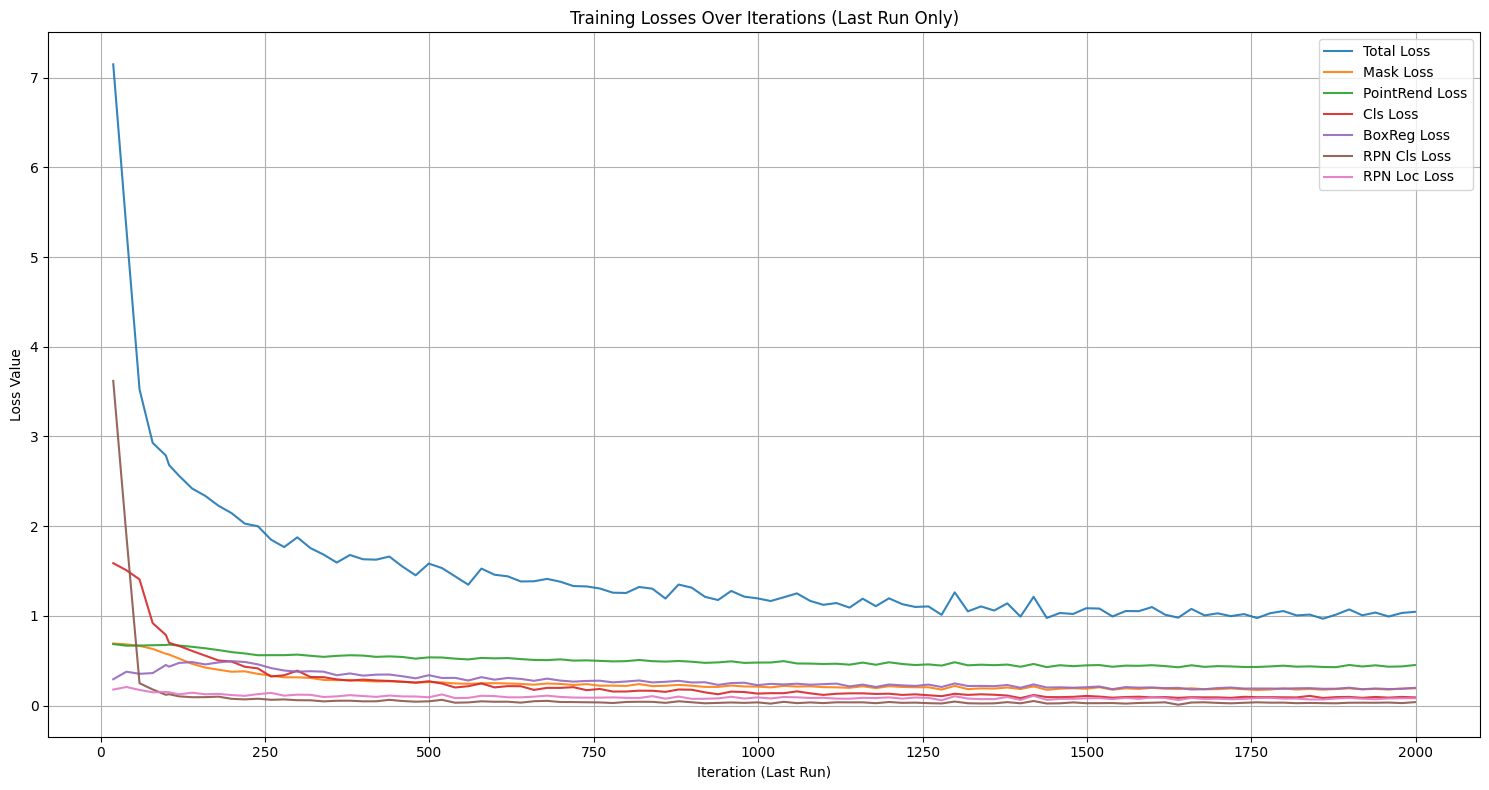

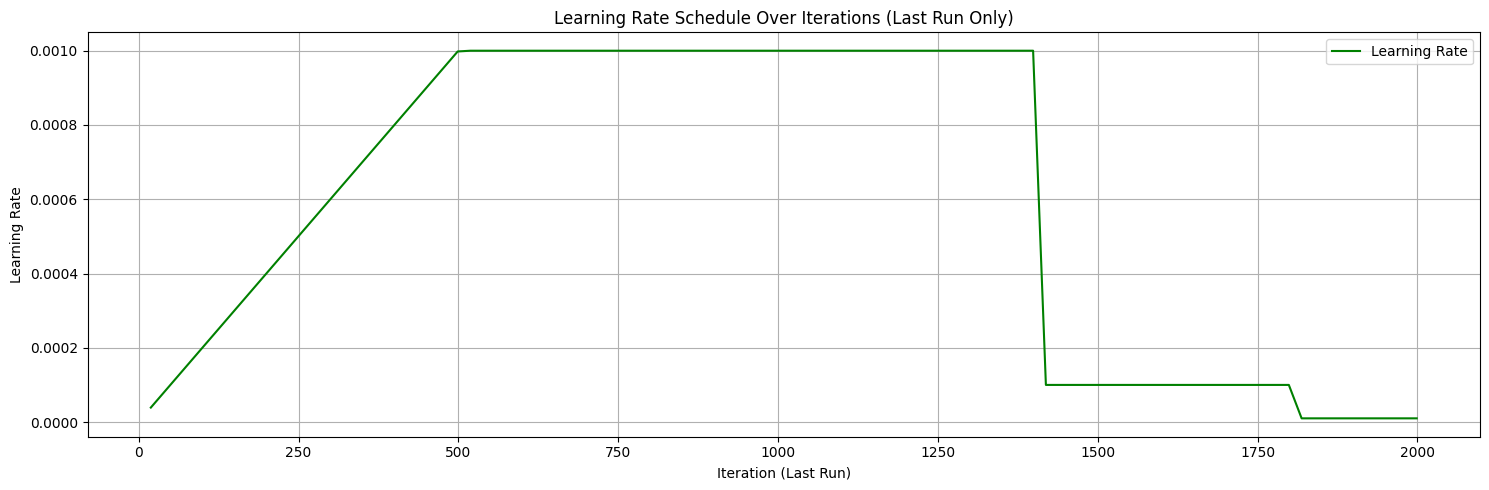

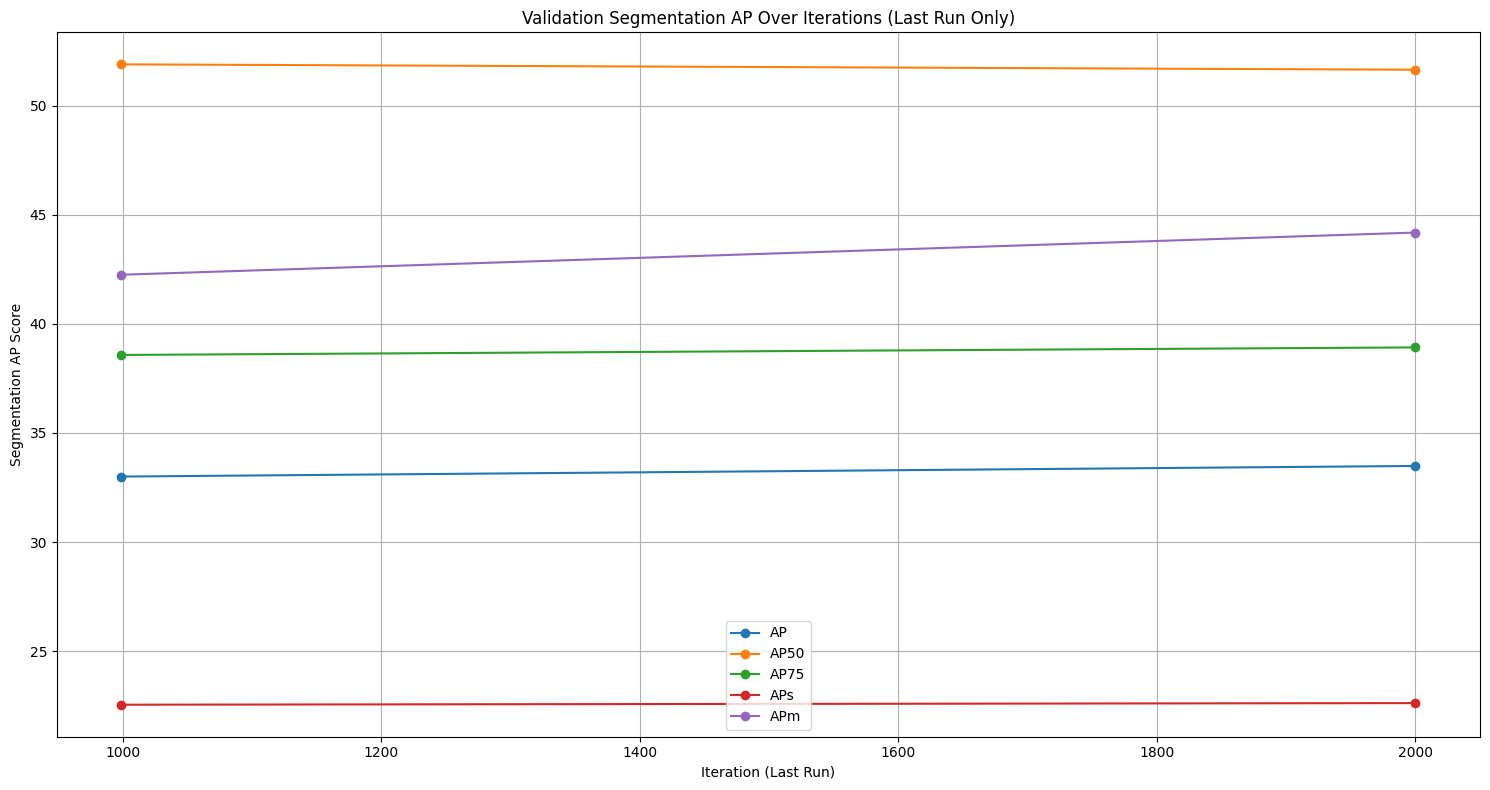

In [11]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import numpy as np
import math


metrics_original_file_path = "/content/drive/MyDrive/hw3-data-release/output_PointRend_X101_PKL_v013_Warmup_Clip_8kIter_Final_v3_AssertionFix/metrics.json"

print(f"將嘗試讀取原始 metrics 檔案: {metrics_original_file_path}")

# --- 1. 讀取與解析 metrics.json ---
data_list_all = []
try:
    with open(metrics_original_file_path, 'r') as f:
        for line_number, line in enumerate(f):
            try:
                clean_line = line.strip()
                if clean_line.endswith(','):
                    clean_line = clean_line[:-1]
                if clean_line:
                    data_list_all.append(json.loads(clean_line))
            except json.JSONDecodeError:
                print(f"警告：跳過無法解析的 JSON 行 (行號 {line_number + 1}): {line.strip()}")

    if not data_list_all:
        print(f"錯誤：從 '{metrics_original_file_path}' 未讀取到任何有效數據。")
        df_metrics_raw_all = pd.DataFrame()
    else:
        df_metrics_raw_all = pd.DataFrame(data_list_all)
        print(f"成功讀取原始 metrics.json，共 {len(df_metrics_raw_all)} 條記錄。")

except FileNotFoundError:
    print(f"錯誤：找不到 metrics.json 檔案於 '{metrics_original_file_path}'。")
    df_metrics_raw_all = pd.DataFrame()
except Exception as e:
    print(f"讀取 metrics.json 時發生其他錯誤: {e}")
    df_metrics_raw_all = pd.DataFrame()

# --- 2. 偵測最後一次訓練運行的起始索引 ---
def find_last_run_start_index(df_raw):
    """
    偵測包含多次運行記錄的 DataFrame 中，最後一次運行的起始索引。
    依據是尋找迭代次數 (iteration) 的重置點。
    """
    last_run_start_idx = 0
    if df_raw.empty or 'iteration' not in df_raw.columns:
        print("DataFrame 為空或缺少 'iteration' 列，無法偵測運行起始。")
        return last_run_start_idx

    iterations_num = pd.to_numeric(df_raw['iteration'], errors='coerce')
    valid_indices_mask = iterations_num.notna()

    if not valid_indices_mask.any():
        print("未找到有效的數值迭代記錄，無法偵測運行起始。")
        return last_run_start_idx

    valid_iterations = iterations_num[valid_indices_mask]
    valid_original_indices = df_raw.index[valid_indices_mask]

    if len(valid_iterations) <= 1:
        return valid_original_indices[0] if len(valid_iterations) == 1 else 0

    prev_iter_val = valid_iterations.iloc[0]
    last_run_start_idx = valid_original_indices[0]


    for i in range(1, len(valid_iterations)):
        current_original_index = valid_original_indices[i]
        current_iter_val = valid_iterations.iloc[i]

        reset_detected = False

        if prev_iter_val > 1000 and current_iter_val < 100:
            reset_detected = True

        elif current_iter_val < prev_iter_val and (prev_iter_val - current_iter_val) > 500:
             reset_detected = True


        if reset_detected:
            last_run_start_idx = current_original_index
            print(f"檢測到潛在運行重置於原始索引 {current_original_index} (迭代 {int(current_iter_val)} 在 {int(prev_iter_val)} 之後)。設定新的起始點。")

        prev_iter_val = current_iter_val

    print(f"最終識別的最後一次訓練運行起始原始索引為: {last_run_start_idx}")
    return last_run_start_idx

# --- 3. 選取最後一次運行的數據並進行預處理 ---
df_metrics_processed = pd.DataFrame() # 初始化
if not df_metrics_raw_all.empty:
    last_run_start_idx = find_last_run_start_index(df_metrics_raw_all)

    df_last_run_raw = df_metrics_raw_all.loc[last_run_start_idx:].copy()
    print(f"已選取最後一次運行的原始記錄 {len(df_last_run_raw)} 條 (從索引 {last_run_start_idx} 開始)。")

    if not df_last_run_raw.empty and 'iteration' in df_last_run_raw.columns:

        df_last_run_raw['iteration'] = pd.to_numeric(df_last_run_raw['iteration'], errors='coerce')
        df_last_run_raw = df_last_run_raw.dropna(subset=['iteration'])

        if not df_last_run_raw.empty:
            df_last_run_raw['iteration'] = df_last_run_raw['iteration'].astype(int)

            df_metrics_processed = df_last_run_raw.drop_duplicates(subset=['iteration'], keep='last').sort_values(by='iteration')
            print(f"處理最後一次運行的重複迭代並排序後，剩餘 {len(df_metrics_processed)} 條記錄用於分析。")
        else:
            print("在選取的最後一次運行數據中，未能找到有效的迭代記錄。")
    else:
        print("選取的最後一次運行數據為空或缺少 'iteration' 列。")
else:
    print("原始 DataFrame 為空，無法進行數據選取和處理。")

# --- 4. 繪製圖表 (使用處理後的最後一次運行的數據) ---
if not df_metrics_processed.empty and 'iteration' in df_metrics_processed.columns:

    # --- 4.1 繪製訓練損失曲線 ---
    loss_cols = {
        'total_loss': 'Total Loss', 'loss_mask': 'Mask Loss', 'loss_mask_point': 'PointRend Loss',
        'loss_cls': 'Cls Loss', 'loss_box_reg': 'BoxReg Loss',
        'loss_rpn_cls': 'RPN Cls Loss', 'loss_rpn_loc': 'RPN Loc Loss',
    }
    available_losses = {k: v for k, v in loss_cols.items() if k in df_metrics_processed.columns}

    if available_losses:
        df_train_log_plot = df_metrics_processed[df_metrics_processed[list(available_losses.keys())].notna().any(axis=1)].copy()
        if not df_train_log_plot.empty:
            plt.figure(figsize=(15, 8))
            for col, label in available_losses.items():
                if col in df_train_log_plot.columns and df_train_log_plot[col].notna().any():
                    plt.plot(df_train_log_plot['iteration'], df_train_log_plot[col], label=label, alpha=0.9)
            plt.xlabel('Iteration (Last Run)')
            plt.ylabel('Loss Value')
            plt.title('Training Losses Over Iterations (Last Run Only)')
            plt.legend(loc='best')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else: print("在最後運行數據中未找到有效的訓練損失記錄。")
    else: print("在最後運行數據中未找到任何可繪製的損失欄位。")

    # --- 4.2 繪製學習率變化 ---
    if 'lr' in df_metrics_processed.columns:
        df_lr_log_plot = df_metrics_processed[df_metrics_processed['lr'].notna()].copy()
        if not df_lr_log_plot.empty:
            plt.figure(figsize=(15, 5))
            plt.plot(df_lr_log_plot['iteration'], df_lr_log_plot['lr'], label='Learning Rate', color='g')
            plt.xlabel('Iteration (Last Run)')
            plt.ylabel('Learning Rate')
            plt.title('Learning Rate Schedule Over Iterations (Last Run Only)')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else: print("在最後運行數據中未找到有效的學習率記錄。")
    else: print("在最後運行數據中未找到 'lr' 欄位。")

    # --- 4.3 繪製驗證集實例分割 AP ---
    segm_ap_cols = {
        'segm/AP': 'AP', 'segm/AP50': 'AP50', 'segm/AP75': 'AP75',
        'segm/APs': 'APs', 'segm/APm': 'APm',
    }
    available_segm_aps = {k: v for k, v in segm_ap_cols.items() if k in df_metrics_processed.columns}

    if available_segm_aps:
        df_eval_segm_plot = df_metrics_processed[df_metrics_processed[list(available_segm_aps.keys())].notna().any(axis=1)].copy()
        if not df_eval_segm_plot.empty:
            plt.figure(figsize=(15, 8))
            for col, label in available_segm_aps.items():
                 if col in df_eval_segm_plot.columns and df_eval_segm_plot[col].notna().any():
                    numeric_values = pd.to_numeric(df_eval_segm_plot[col], errors='coerce').replace(-1.0, np.nan)
                    if not numeric_values.isna().all():
                        plt.plot(df_eval_segm_plot['iteration'], numeric_values, marker='o', linestyle='-', label=label)
            plt.xlabel('Iteration (Last Run)')
            plt.ylabel('Segmentation AP Score')
            plt.title('Validation Segmentation AP Over Iterations (Last Run Only)')
            plt.legend(loc='best')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else: print("在最後運行數據中未找到有效的分割 AP 記錄。")
    else: print("在最後運行數據中未找到任何可繪製的分割 AP 欄位。")


else:
    print("無法進行繪圖，因為處理後的 DataFrame 為空或缺少 'iteration' 列。")